In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image
from PIL import Image
import gc

## 1. Description
The goal of this project is to use Generative Adversarial Networks (GANs), specifically a CycleGAN, to transform ordinary photos into images that mimic the style of Claude Monet's paintings. The CycleGAN will learn to translate images from the domain of photographs to the domain of Monet paintings without needing paired examples of photos and paintings.

Monet Paintings Dataset:
- Number of images: 300
- Unique dimensions: [[256 256]]
- Color modes: {'RGB'}

Photos Dataset:
- Number of images: 7038
- Unique dimensions: [[256 256]]
- Color modes: {'RGB'}

In [2]:
# Load a few Monet paintings
monet_images_dir = './data/monet_jpg'
monet_images = [Image.open(os.path.join(monet_images_dir, img)) for img in os.listdir(monet_images_dir)[:5]]

# Load a few photos
photo_images_dir = './data/photo_jpg'
photo_images = [Image.open(os.path.join(photo_images_dir, img)) for img in os.listdir(photo_images_dir)[:5]]

In [3]:
# Function to get dataset statistics
def get_dataset_stats(image_dir):
    image_count = 0
    dimensions = []
    color_modes = set()

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        with Image.open(img_path) as img:
            image_count += 1
            dimensions.append(img.size)  # (width, height)
            color_modes.add(img.mode)

    dimensions = np.array(dimensions)
    unique_dimensions = np.unique(dimensions, axis=0)

    print(f"Number of images: {image_count}")
    print(f"Unique dimensions: {unique_dimensions}")
    print(f"Color modes: {color_modes}")

# Describing Monet paintings dataset
print("Monet Paintings Dataset:")
monet_images_dir = './data/monet_jpg'
get_dataset_stats(monet_images_dir)

# Describing Photos dataset
print("\nPhotos Dataset:")
photo_images_dir = './data/photo_jpg'
get_dataset_stats(photo_images_dir)

Monet Paintings Dataset:
Number of images: 300
Unique dimensions: [[256 256]]
Color modes: {'RGB'}

Photos Dataset:
Number of images: 7038
Unique dimensions: [[256 256]]
Color modes: {'RGB'}


## 2. EDA

Monet Paintings:


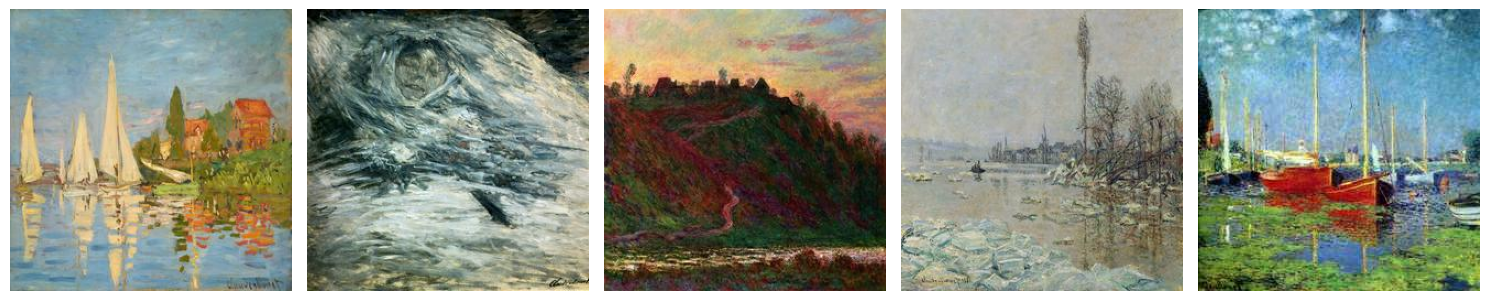

Photos:


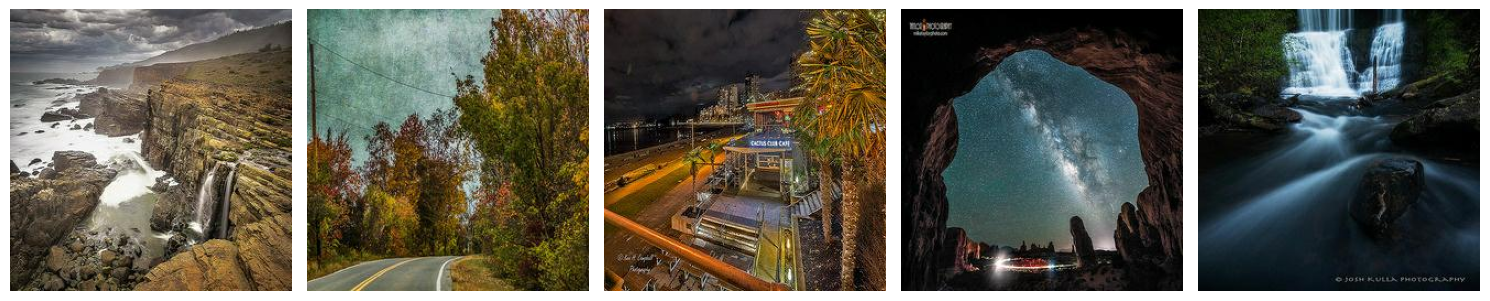

In [4]:
# Function to display a grid of images
def show_images(images, titles=None, cols=5, figsize=(15, 10)):
    assert (titles is None or len(images) == len(titles))
    n_images = len(images)
    cols = int(cols)  # Ensure that cols is an integer
    rows = np.ceil(n_images / float(cols)).astype(int)  # Calculate the number of rows as an integer
    fig = plt.figure(figsize=figsize)
    for n in range(n_images):
        ax = fig.add_subplot(rows, cols, n + 1)
        ax.imshow(images[n])
        if titles is not None:
            ax.set_title(titles[n])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load a few Monet paintings
monet_images_dir = './data/monet_jpg'
monet_images = [Image.open(os.path.join(monet_images_dir, img)) for img in os.listdir(monet_images_dir)[:5]]

# Load a few photos
photo_images_dir = './data/photo_jpg'
photo_images = [Image.open(os.path.join(photo_images_dir, img)) for img in os.listdir(photo_images_dir)[:5]]

# Display Monet paintings
print("Monet Paintings:")
show_images(monet_images)

# Display Photos
print("Photos:")
show_images(photo_images)

## 3. Model Architecture

### Comparison
#### 1. Standard GAN
In a standard GAN, there are two main components:
- Generator (G): This model generates new data instances (e.g., images) that resemble the training data. Its goal is to create data that the discriminator cannot distinguish from real data.
- Discriminator (D): This model evaluates the data produced by the generator against real data. Its goal is to correctly classify data as either "real" (from the training set) or "fake" (generated by G).

#### 2. CycleGAN
- Two Generators:
  - Generator G: Transforms images from domain X (e.g., photos) to domain Y (e.g., Monet-style paintings).
  - Generator F: Transforms images from domain Y (Monet-style paintings) back to domain X (photos).
- Two Discriminators:
  - Discriminator D_X: Tries to distinguish between real images from domain X and fake images generated by F.
  - Discriminator D_Y: Tries to distinguish between real images from domain Y and fake images generated by G.
- Cycle Consistency Loss:
  - To ensure that the transformation is meaningful, CycleGAN introduces the concept of cycle consistency. This means if you transform an image to the other domain and back again, you should get the original image. 
- Identity Loss (Optional but often used):This loss ensures that if you input an image from one domain into the generator corresponding to that domain, it should produce the same image. 


### Summary
The code I've been working on implements a CycleGAN, which is a specific type of GAN designed for unpaired image-to-image translation. Unlike a standard GAN, which might generate new images from random noise, a CycleGAN is focused on transforming images from one domain to another (e.g., turning photos into Monet-style paintings).

### 1. Define

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Generator
class SimpleGenerator(nn.Module):
    def __init__(self, num_layers=6):
        super(SimpleGenerator, self).__init__()
        self.num_layers = num_layers
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Downsampling layers
        self.down_sampling = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
            
        # Residual blocks
        res_blocks = []
        for _ in range(num_layers):
            res_blocks += [ResidualBlock(256)]
        self.res_blocks = nn.Sequential(*res_blocks)
            
        # Upsampling layers
        self.up_sampling = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.output = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.down_sampling(x)
        x = self.res_blocks(x)
        x = self.up_sampling(x)
        return self.output(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.instance_norm(self.conv1(x)))
        out = self.instance_norm(self.conv2(out))
        out += residual
        return self.relu(out)

# Discriminator
class SimpleDiscriminator(nn.Module):
    def __init__(self, num_layers=4):
        super(SimpleDiscriminator, self).__init__()
        self.num_layers = num_layers
        
        model = [
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        current_dim = 64
        for _ in range(1, num_layers):  # The first layer is already added
            new_dim = min(current_dim * 2, 512)
            model += [
                nn.Conv2d(current_dim, new_dim, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(new_dim),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            current_dim = new_dim

        model += [nn.Conv2d(current_dim, 1, kernel_size=4, stride=1, padding=1)]
        
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

### 2. Data Preparation
Including Image Augmentation

In [95]:
class CustomTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(0.5),            # Randomly flip the image horizontally
            transforms.RandomRotation(10),               # Randomly rotate the image by +/- 10 degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate the image by up to 10%
            transforms.ToTensor(),                       # Convert the image to a tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # Normalize the image
        ])

    def __call__(self, img):
        img = self.transforms(img)
        return img

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('jpg', 'png'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
                                        ])(image)
        return image

def get_data_loaders(monet_dir, photo_dir, batch_size, stage='fit'):
    batch_size = max(1, int(batch_size))

    monet_dataset = CustomImageDataset(monet_dir, transform=CustomTransform())
    monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)

    if stage == "fit":
        photo_dataset = CustomImageDataset(photo_dir, transform=CustomTransform())
    elif stage in ["test", "predict"]:
        photo_dataset = CustomImageDataset(photo_dir)

    photo_loader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)
    
    return monet_loader, photo_loader

### 3. Initial Training

In [7]:
def train(generator, discriminator, monet_loader, photo_loader, num_epochs, device, lr=0.0002):
    criterion = nn.MSELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        for i, (monet_imgs, photo_imgs) in enumerate(zip(monet_loader, photo_loader)):
            real_monet = monet_imgs[0].to(device)
            real_photo = photo_imgs[0].to(device)
            
            # Train Discriminator
            optimizer_D.zero_grad()
            fake_monet = generator(real_photo)
            d_loss_real = criterion(discriminator(real_monet), torch.ones_like(discriminator(real_monet)))
            d_loss_fake = criterion(discriminator(fake_monet.detach()), torch.zeros_like(discriminator(fake_monet)))
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            g_loss = criterion(discriminator(fake_monet), torch.ones_like(discriminator(fake_monet)))
            g_loss.backward()
            optimizer_G.step()
            
        print(f"Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
        
        if (epoch + 1) % 10 == 0:
            torch.save(generator.state_dict(),  os.path.join(output_dir, f'generator_epoch_{epoch+1}.pth'))
            torch.save(generator.state_dict(),  os.path.join(output_dir, f'discriminator_epoch_{epoch+1}.pth'))
    
    return generator, discriminator


### 4. MiFID Evaluation

In [ ]:
from torchvision.models import inception_v3

class InceptionV3(nn.Module):
    def __init__(self):
        super(InceptionV3, self).__init__()
        inception = inception_v3(pretrained=True)
        self.block1 = nn.Sequential(
            inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3, nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.block2 = nn.Sequential(
            inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.block3 = nn.Sequential(
            inception.Mixed_5b, inception.Mixed_5c,
            inception.Mixed_5d, inception.Mixed_6a,
            inception.Mixed_6b, inception.Mixed_6c,
            inception.Mixed_6d, inception.Mixed_6e
        )
        self.block4 = nn.Sequential(
            inception.Mixed_7a, inception.Mixed_7b,
            inception.Mixed_7c, nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x.view(x.size(0), -1)

def calculate_activation_statistics(images, model, batch_size=50, dims=2048):
    model.eval()
    act = np.empty((len(images), dims))
    
    for i in tqdm(range(0, len(images), batch_size)):
        batch = images[i:i+batch_size].to(device)
        pred = model(batch)[0]
        act[i:i+batch_size] = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = f"fid calculation produces singular product; adding {eps} to diagonal of cov estimates"
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError(f"Imaginary component {m}")
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def calculate_mifid(real_images, fake_images, batch_size=50, device='cuda'):
    inception_model = InceptionV3().to(device)
    inception_model.eval()

    mu_real, sigma_real = calculate_activation_statistics(real_images, inception_model, batch_size, device=device)
    mu_fake, sigma_fake = calculate_activation_statistics(fake_images, inception_model, batch_size, device=device)

    mifid_score = calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)
    return mifid_score


## 4. Results and Analysis


### 1. Hyperparameter Tuning

In [8]:
from tqdm import tqdm
from scipy import linalg
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Define the hyperparameter search space
space = [
    Real(1e-5, 1e-3, name='learning_rate', prior='log-uniform'),
    Integer(2, 32, name='batch_size'),
    Integer(4, 8, name='generator_layers'),
    Integer(3, 6, name='discriminator_layers')
]

# Objective function for Bayesian optimization
@use_named_args(space)
def objective(**params):
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    generator_layers = params['generator_layers']
    discriminator_layers = params['discriminator_layers']

    # Create models with current hyperparameters
    generator = SimpleGenerator(num_layers=generator_layers).to(device)
    discriminator = SimpleDiscriminator(num_layers=discriminator_layers).to(device)

    # Update data loaders with new batch size
    monet_loader, photo_loader = get_data_loaders('./data/monet_jpg/', './data/photo_jpg/', batch_size=batch_size)

    # Train for a few epochs
    generator, discriminator = train(generator, discriminator, monet_loader, photo_loader, num_epochs=5, device=device, lr=learning_rate)

    # Evaluate
    score = evaluate_model(generator, discriminator, monet_loader, photo_loader, device)

    return score

# Hyperparameter tuning function using Bayesian optimization
def hyperparameter_tuning(device):
    result = gp_minimize(objective, space, n_calls=50, random_state=42, verbose=True)
    
    best_params = {
        'learning_rate': result.x[0],
        'batch_size': result.x[1],
        'generator_layers': result.x[2],
        'discriminator_layers': result.x[3]
    }
    
    return best_params

# Evaluation function for hyperparameter tuning
def evaluate_model(generator, discriminator, monet_loader, photo_loader, device):
    generator.eval()
    discriminator.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for monet_imgs, photo_imgs in zip(monet_loader, photo_loader):
            real_monet = monet_imgs[0].to(device)
            real_photo = photo_imgs[0].to(device)

            fake_monet = generator(real_photo)
            fake_score = discriminator(fake_monet)
            real_score = discriminator(real_monet)

            loss = ((fake_score - 1) ** 2).mean() + ((real_score - 1) ** 2).mean()
            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches

In [9]:
output_dir = 'model'
os.makedirs(output_dir, exist_ok=True)

# Hyperparameter tuning
print("Starting hyperparameter tuning...")
best_params = hyperparameter_tuning(device)
print(f"Best hyperparameters: {best_params}")

Starting hyperparameter tuning...
Iteration No: 1 started. Evaluating function at random point.
Epoch [1/5], D_loss: 0.2280, G_loss: 0.4650
Epoch [2/5], D_loss: 0.2107, G_loss: 0.6537
Epoch [3/5], D_loss: 0.4069, G_loss: 0.3639
Epoch [4/5], D_loss: 0.4175, G_loss: 0.5024
Epoch [5/5], D_loss: 0.2219, G_loss: 0.6869
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 66.0283
Function value obtained: 1.1084
Current minimum: 1.1084
Iteration No: 2 started. Evaluating function at random point.
Epoch [1/5], D_loss: 0.2707, G_loss: 0.6248
Epoch [2/5], D_loss: 0.2522, G_loss: 0.3662
Epoch [3/5], D_loss: 0.2969, G_loss: 0.3260
Epoch [4/5], D_loss: 0.2374, G_loss: 0.2876
Epoch [5/5], D_loss: 0.2423, G_loss: 0.3911
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 39.2691
Function value obtained: 0.5404
Current minimum: 0.5404
Iteration No: 3 started. Evaluating function at random point.
Epoch [1/5], D_loss: 0.3531, G_loss: 0.5120
Epoch [2/5], D_loss: 0.2825, G_l

In [11]:
# Reinitialize data loaders with best batch size
monet_loader, photo_loader = get_data_loaders('./data/monet_jpg/', './data/photo_jpg/', batch_size=best_params['batch_size'])

# Initialize models with best hyperparameters
generator = SimpleGenerator(num_layers=best_params['generator_layers']).to(device)
discriminator = SimpleDiscriminator(num_layers=best_params['discriminator_layers']).to(device)

# Initial training with best hyperparameters
print("Starting initial training with best hyperparameters...")
generator, discriminator = train(generator, discriminator, monet_loader, photo_loader, num_epochs=100, device=device, lr=best_params['learning_rate'])

Best hyperparameters: {'learning_rate': 0.00016722697006183674, 'batch_size': 2, 'generator_layers': 4, 'discriminator_layers': 5}
Starting initial training with best hyperparameters...
Epoch [1/100], D_loss: 0.3643, G_loss: 0.6817
Epoch [2/100], D_loss: 0.1775, G_loss: 0.3660
Epoch [3/100], D_loss: 0.3197, G_loss: 0.3988
Epoch [4/100], D_loss: 0.3567, G_loss: 0.3927
Epoch [5/100], D_loss: 0.2537, G_loss: 1.1693
Epoch [6/100], D_loss: 0.1314, G_loss: 0.7896
Epoch [7/100], D_loss: 0.2533, G_loss: 0.8390
Epoch [8/100], D_loss: 0.5121, G_loss: 0.4243
Epoch [9/100], D_loss: 0.0670, G_loss: 0.9111
Epoch [10/100], D_loss: 0.0877, G_loss: 0.8548
Epoch [11/100], D_loss: 0.1045, G_loss: 1.1122
Epoch [12/100], D_loss: 0.2479, G_loss: 0.4244
Epoch [13/100], D_loss: 0.3430, G_loss: 0.2197
Epoch [14/100], D_loss: 0.2693, G_loss: 1.0356
Epoch [15/100], D_loss: 0.2379, G_loss: 0.4638
Epoch [16/100], D_loss: 0.1237, G_loss: 0.8912
Epoch [17/100], D_loss: 0.1690, G_loss: 1.0074
Epoch [18/100], D_loss: 

### 2. Fine-tuning

In [15]:
def fine_tune(generator, discriminator, monet_loader, photo_loader, num_epochs, device, best_params):
    # Use the best learning rate from hyperparameter tuning, but reduce it for fine-tuning
    lr = best_params['learning_rate'] * 0.1  # Reduce learning rate for fine-tuning

    # Use the best batch size from hyperparameter tuning
    batch_size = best_params['batch_size']

    # Loss function
    criterion = nn.MSELoss()

    # Optimizer setup using the fine-tuned learning rate
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for i, (monet_imgs, photo_imgs) in enumerate(zip(monet_loader, photo_loader)):
            real_monet = monet_imgs[0].to(device)
            real_photo = photo_imgs[0].to(device)
    
            # Ensure the batch sizes match
            current_batch_size = min(real_monet.size(0), real_photo.size(0))
            real_monet = real_monet[:current_batch_size]
            real_photo = real_photo[:current_batch_size]

            # Fine-tune Discriminator
            optimizer_D.zero_grad()
            fake_monet = generator(real_photo)
            d_loss_real = criterion(discriminator(real_monet), torch.ones_like(discriminator(real_monet)))
            d_loss_fake = criterion(discriminator(fake_monet.detach()), torch.zeros_like(discriminator(fake_monet)))
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()
            
            # Fine-tune Generator
            optimizer_G.zero_grad()
            g_loss = criterion(discriminator(fake_monet), torch.ones_like(discriminator(fake_monet)))
            g_loss.backward()
            optimizer_G.step()
            
        print(f"Fine-tuning Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
        
        if (epoch + 1) % 5 == 0:
            torch.save(generator.state_dict(),  os.path.join(output_dir, f'generator_finetuned_epoch_{epoch+1}.pth'))
            torch.save(generator.state_dict(),  os.path.join(output_dir, f'discriminator_finetuned_epoch_{epoch+1}.pth'))
           
    return generator, discriminator


In [16]:
# Fine-tuning
print("Starting fine-tuning...")
generator, discriminator = fine_tune(generator, discriminator, monet_loader, photo_loader, num_epochs=50, device=device, best_params=best_params)

Starting fine-tuning...
Fine-tuning Epoch [1/50], D_loss: 0.1976, G_loss: 0.4733
Fine-tuning Epoch [2/50], D_loss: 0.1033, G_loss: 0.6475
Fine-tuning Epoch [3/50], D_loss: 0.1668, G_loss: 0.4776
Fine-tuning Epoch [4/50], D_loss: 0.0242, G_loss: 0.7244
Fine-tuning Epoch [5/50], D_loss: 0.0839, G_loss: 0.6151
Fine-tuning Epoch [6/50], D_loss: 0.2029, G_loss: 0.4109
Fine-tuning Epoch [7/50], D_loss: 0.0532, G_loss: 0.6106
Fine-tuning Epoch [8/50], D_loss: 0.1294, G_loss: 0.6440
Fine-tuning Epoch [9/50], D_loss: 0.2905, G_loss: 0.4105
Fine-tuning Epoch [10/50], D_loss: 0.0509, G_loss: 0.6036
Fine-tuning Epoch [11/50], D_loss: 0.0237, G_loss: 0.7990
Fine-tuning Epoch [12/50], D_loss: 0.1882, G_loss: 0.3972
Fine-tuning Epoch [13/50], D_loss: 0.1379, G_loss: 0.8987
Fine-tuning Epoch [14/50], D_loss: 0.0645, G_loss: 0.7499
Fine-tuning Epoch [15/50], D_loss: 0.1141, G_loss: 0.7889
Fine-tuning Epoch [16/50], D_loss: 0.0131, G_loss: 1.2153
Fine-tuning Epoch [17/50], D_loss: 0.0813, G_loss: 0.5571

In [117]:
def generate_and_save_images(generator, photo_loader, num_images, output_dir, device):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'original'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'generated'), exist_ok=True)

    generator.eval()

    with torch.no_grad():
        for i, (batch_images, _) in tqdm(enumerate(photo_loader), total=num_images):
            if i >= num_images:
                break
            batch_images = batch_images.to(device)
            fake_images = generator(batch_images)

            # Save original images
            save_image(batch_images, os.path.join(output_dir, 'original', f'original_{i}.jpg'), normalize=True)

            # Save generated images
            save_image(fake_images, os.path.join(output_dir, 'generated', f'generated_{i}.jpg'), normalize=True)

def create_comparison_plot(output_dir, num_samples=5):
    original_dir = os.path.join(output_dir, 'original')
    generated_dir = os.path.join(output_dir, 'generated')

    original_images = sorted(os.listdir(original_dir))[:num_samples]
    generated_images = sorted(os.listdir(generated_dir))[:num_samples]

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    fig.suptitle("Original vs Generated Images", fontsize=16)

    for i in range(num_samples):
        # Original image
        img_orig = plt.imread(os.path.join(original_dir, original_images[i]))
        axes[i, 0].imshow(img_orig)
        axes[i, 0].set_title(f"Original {i+1}")
        axes[i, 0].axis('off')

        # Generated image
        img_gen = plt.imread(os.path.join(generated_dir, generated_images[i]))
        axes[i, 1].imshow(img_gen)
        axes[i, 1].set_title(f"Generated {i+1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'comparison_plot.png'))
    # plt.close()

### 4. Generate Images

100%|██████████| 10/10 [00:01<00:00,  8.97it/s]


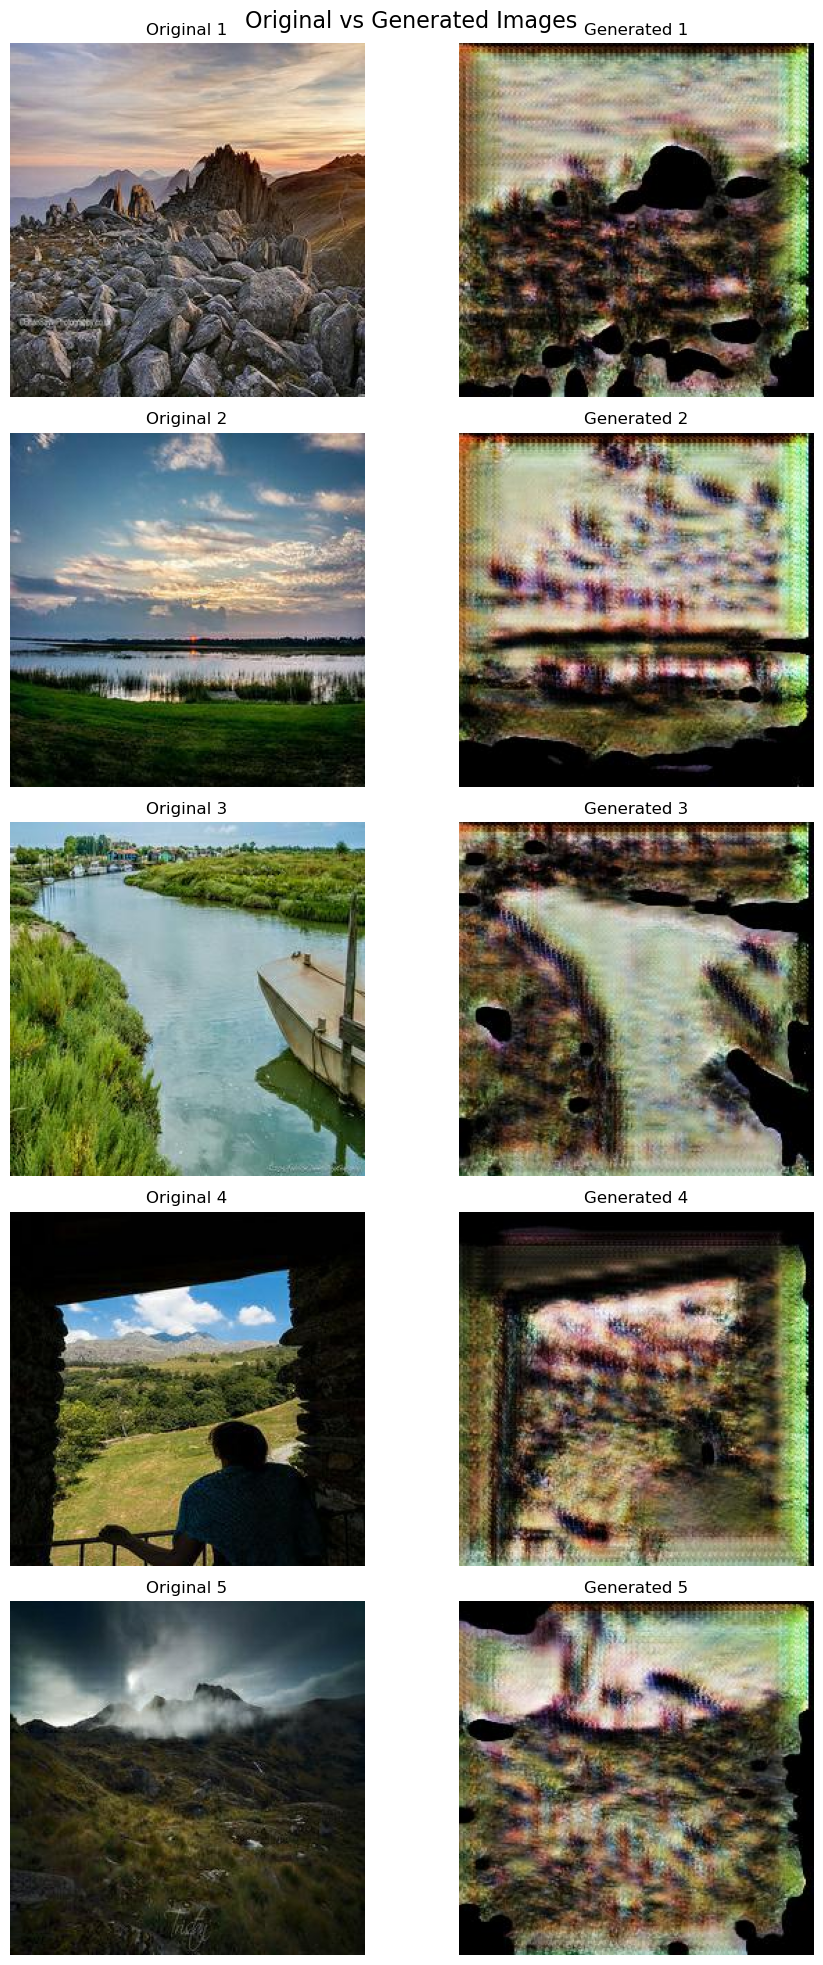

In [118]:
_, photo_loader = get_data_loaders('./data/monet_jpg/', './data/photo_jpg/', batch_size=best_params['batch_size'], stage='test')
generate_and_save_images(generator, photo_loader, num_images=10, output_dir='output', device=device)
create_comparison_plot(output_dir='output', num_samples=5)

In [119]:
def load_pretrained_generator(model_path, device):
    generator = SimpleGenerator().to(device)
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()
    return generator

# generator = load_pretrained_generator('./output/generator_epoch_70.pth', device)

## 5. Conclusion

### 1. Strengths:

- Comprehensive approach: The project covers all major steps from data preparation to model evaluation.
- Hyperparameter tuning: Uses Bayesian optimization for finding optimal hyperparameters.
- Data augmentation: Implements various image augmentation techniques to improve model generalization.
- Evaluation metrics: Includes MiFID (Modified Inception Frechet Distance) for quantitative evaluation.
### 2. Areas for Improvement:
- Model complexity: The current generator and discriminator architectures are relatively simple. Consider implementing more advanced architectures like ResNet-based models.
- Training stability: GANs can be unstable during training. Consider implementing techniques like gradient penalty or spectral normalization to improve stability.
- Evaluation: While MiFID is implemented, it's not used in the training loop. Consider integrating it into the training process for model selection.